<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_catalogues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 29.3 MB/s eta 0:00:00


In [16]:
from astroquery.sdss import SDSS
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
query = """
SELECT TOP 10000
       p.ra, p.dec,
       p.u, p.g, p.r, p.i, p.z,
       s.z as redshift,
       s.class as specClass
FROM SpecObjAll s
JOIN PhotoObjAll p ON s.bestObjID = p.objid
WHERE s.class in ('STAR', 'GALAXY', 'QSO')
  AND p.clean = 1
  AND p.u between 0 AND 30  -- Exclude obviously invalid magnitudes
  AND p.g between 0 AND 30
  AND p.r between 0 AND 30
  AND p.i between 0 AND 30
  AND p.z between 0 AND 30
ORDER BY NEWID()  -- Randomize the sample
"""

In [4]:
res = SDSS.query_sql(query)

In [6]:
df_sdss = res.to_pandas()
df_sdss.head()

,ra,dec,u,g,r,i,z,redshift,specClass
0,19.064521,17.722450,23.21150,22.12046,22.15965,21.88805,21.07335,1.691955,QSO
1,32.765177,21.526979,21.65323,20.10863,19.33804,18.99185,18.76622,0.000007,STAR
2,225.293140,8.552339,21.36565,20.90102,20.63496,20.66467,20.31698,0.850778,QSO
3,213.446193,52.590463,19.10860,19.16848,18.82102,18.86141,19.08483,1.201062,QSO
4,124.885965,40.191876,20.71204,19.60363,19.32135,19.27178,19.44086,0.000098,STAR


In [7]:
# Suppose df_sdss has columns: u, g, r, i, z
df_sdss['u_g'] = df_sdss['u'] - df_sdss['g']
df_sdss['g_r'] = df_sdss['g'] - df_sdss['r']
df_sdss['r_i'] = df_sdss['r'] - df_sdss['i']
df_sdss['i_z'] = df_sdss['i'] - df_sdss['z']

# View the new color-index columns
df_sdss[['u_g', 'g_r', 'r_i', 'i_z']].head()

,u_g,g_r,r_i,i_z
0,1.09104,-0.03919,0.27160,0.81470
1,1.54460,0.77059,0.34619,0.22563
2,0.46463,0.26606,-0.02971,0.34769
3,-0.05988,0.34746,-0.04039,-0.22342
4,1.10841,0.28228,0.04957,-0.16908


In [8]:
from sklearn.model_selection import train_test_split

features = ["u", "g", "r", "i", "z"]  # Or your color indices
labels = "specClass"

X = df_sdss[features].values
y = df_sdss[labels].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print("Training inputs: ",X_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",X_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (8000, 5)
Training outputs:  (8000,)
Testing inputs:  (2000, 5)
Testing outputs:  (2000,)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(max_depth=2,random_state=42,)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

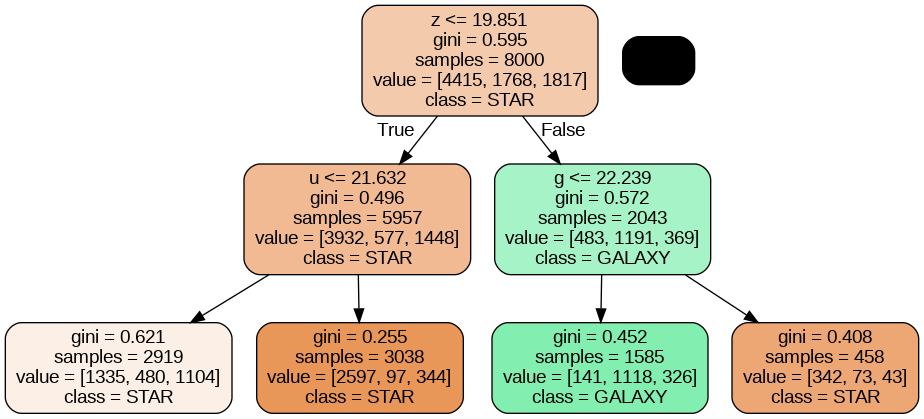

In [10]:
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

#dot_data=export_graphviz(dt)
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=features,
    class_names=["STAR", "GALAXY", "QSO"],
    filled=True,
    rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      GALAXY       0.67      0.97      0.79      1104
         QSO       0.71      0.62      0.66       442
        STAR       0.00      0.00      0.00       454

    accuracy                           0.67      2000
   macro avg       0.46      0.53      0.48      2000
weighted avg       0.52      0.67      0.58      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Below are brief definitions of **precision**, **recall**, and **F1** along with their LaTeX expressions. You can include these as Markdown cells in your Jupyter notebook (or any markdown-friendly environment).

---

## Precision
**Precision** is the fraction of predicted positives (i.e., the objects your model labeled as positive) that are actually positive:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$



- **TP** = True Positives: Items correctly labeled as positive.  
- **FP** = False Positives: Items incorrectly labeled as positive.

---

## Recall
**Recall** (or sensitivity) is the fraction of actual positives that are correctly identified:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **TP** = True Positives.  
- **FN** = False Negatives: Items that were positive but incorrectly labeled as negative.

---

## F1 Score
The **F1 score** is the harmonic mean of precision and recall:

$$
F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

F1 ranges between 0 and 1, with 1 indicating perfect precision and recall.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

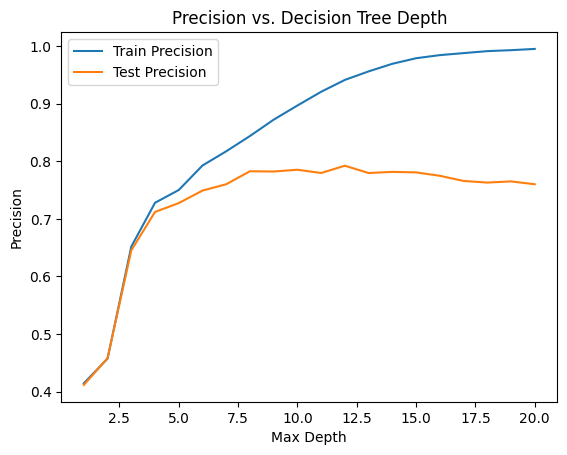

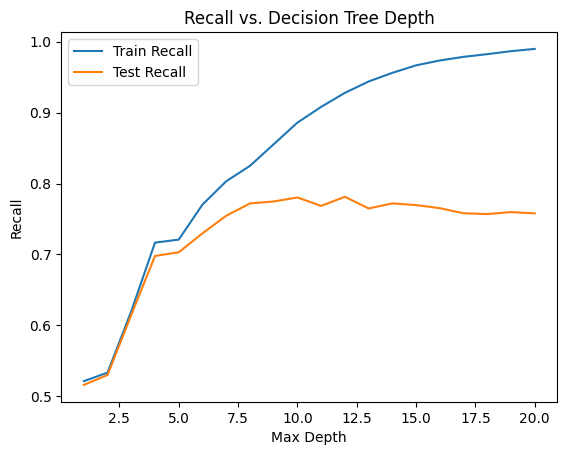

In [17]:
from sklearn.metrics import precision_score, recall_score

max_depths = range(1, 21)  # Decision tree depths to try
train_precision = []
test_precision = []
train_recall = []
test_recall = []

for d in max_depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)

    # Predictions
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)

    # Precision
    train_precision.append(
        precision_score(y_train, y_train_pred, average='macro')  # or 'macro' for multi-class
    )
    test_precision.append(
        precision_score(y_test, y_test_pred, average='macro')
    )

    # Recall
    train_recall.append(
        recall_score(y_train, y_train_pred, average='macro')
    )
    test_recall.append(
        recall_score(y_test, y_test_pred, average='macro')
    )

# --- PLOT PRECISION ---
plt.plot(max_depths, train_precision, label='Train Precision')
plt.plot(max_depths, test_precision, label='Test Precision')
plt.xlabel('Max Depth')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs. Decision Tree Depth')
plt.show()

# --- PLOT RECALL ---
plt.plot(max_depths, train_recall, label='Train Recall')
plt.plot(max_depths, test_recall, label='Test Recall')
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall vs. Decision Tree Depth')
plt.show()